In [59]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import re
import pickle
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from collections import Counter

In [60]:
data_dir = r"C:\Users\13658\Desktop\LaTex_Code_Generator"
handwritten_equations = os.path.join(data_dir, "Handwritten_equations")
json_dict = os.path.join(data_dir, "char_dict.json")
csv_file = os.path.join(data_dir, "caption_data.csv")

In [61]:
def smart_clean_latex(code):
    preserved = re.findall(r'(\\[a-zA-Z]+)\s+', code)
    for cmd in preserved:
        code = code.replace(cmd + ' ', f'{cmd}<<<SPACE>>>')
    code = code.replace(' ', '')
    code = code.replace('<<<SPACE>>>', ' ')
    return code

csv_data = pd.read_csv(csv_file)
latex_codes_raw = csv_data['Column2'].values
latex_codes = [smart_clean_latex(code) for code in latex_codes_raw]
image_names = csv_data['Column1'].values

In [62]:
command_tokens = set()
for code in latex_codes:
    i = 0
    while i < len(code):
        if code[i] == '\\':
            j = i + 1
            while j < len(code) and code[j].isalpha():
                j += 1
            command_tokens.add(code[i:j])
            i = j
        else:
            i += 1

def mixed_tokenize_latex(code, command_set):
    tokens = []
    i = 0
    while i < len(code):
        if code[i] == '\\':
            j = i + 1
            while j < len(code) and code[j].isalpha():
                j += 1
            cmd = code[i:j]
            if cmd in command_set:
                tokens.append(cmd)
                i = j
                continue
        tokens.append(code[i])
        i += 1
    return tokens

token_counter = Counter()
for code in latex_codes:
    tokens = mixed_tokenize_latex(code, command_tokens)
    token_counter.update(tokens)

special_tokens = ['<pad>', '<s>', '</s>']
token_list = special_tokens + sorted(token_counter.keys())

token2idx = {token: idx for idx, token in enumerate(token_list)}
idx2token = {idx: token for token, idx in token2idx.items()}
vocab_size = len(token2idx)

def encode_label_mixed(code, token2idx, command_set, max_len):
    tokens = ['<s>'] + mixed_tokenize_latex(code, command_set)[:max_len - 2] + ['</s>']
    label = np.zeros(max_len, dtype=np.int32)
    for t, token in enumerate(tokens):
        label[t] = token2idx.get(token, 0)
    return label

max_seq_length = max(len(mixed_tokenize_latex(code, command_tokens)) for code in latex_codes) + 2
print(f"Dic Length: {vocab_size}")
print(f"Maximum Sequence Length: {max_seq_length}")

Dic Length: 113
Maximum Sequence Length: 224


In [63]:
def preprocess_image(image_path, target_size=(464, 85)):
    img = Image.open(image_path).convert('L')
    img.thumbnail(target_size, Image.Resampling.LANCZOS)

    delta_w = target_size[0] - img.size[0]
    delta_h = target_size[1] - img.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    img = ImageOps.expand(img, padding, fill=255)

    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.stack([img_array] * 3, axis=0)
    return torch.from_numpy(img_array).float()


class LatexDataset(Dataset):
    def __init__(self, image_dir, image_names, latex_codes, max_len):
        self.image_dir = image_dir
        self.image_names = image_names
        self.latex_codes = latex_codes
        self.max_len = max_len

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, f"{self.image_names[idx]}.bmp")
        img = preprocess_image(img_path)
        label = encode_label_mixed(self.latex_codes[idx], token2idx, command_tokens, self.max_len)
        img_tensor = img.expand(3, -1, -1)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor, label_tensor


def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    return images, labels, [len(l) for l in labels]

train_imgs, val_imgs, train_codes, val_codes = train_test_split(
    image_names, latex_codes, test_size=0.3, random_state=42)

train_dataset = LatexDataset(handwritten_equations, train_imgs, train_codes, max_seq_length)
val_dataset = LatexDataset(handwritten_equations, val_imgs, val_codes, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

token2idx/idx2token stored in C:\Users\13658\Desktop\LaTex_Code_Generator\token_dicts


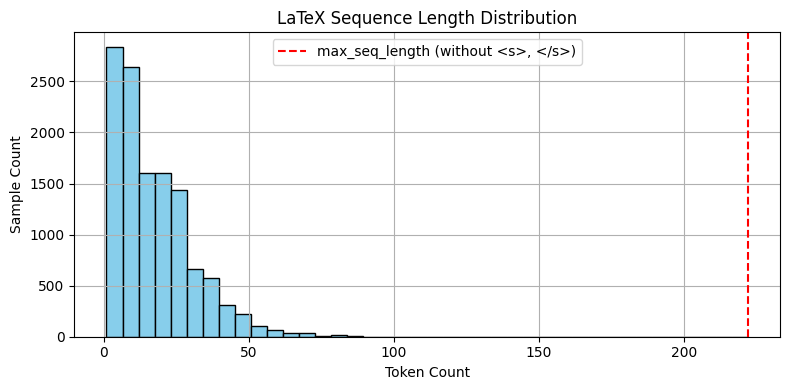

In [64]:
dict_dir = os.path.join(data_dir, "token_dicts")
os.makedirs(dict_dir, exist_ok=True)

with open(os.path.join(dict_dir, "token2idx.pkl"), "wb") as f:
    pickle.dump(token2idx, f)

with open(os.path.join(dict_dir, "idx2token.pkl"), "wb") as f:
    pickle.dump(idx2token, f)

print(f"token2idx/idx2token stored in {dict_dir}")

seq_lens = [len(mixed_tokenize_latex(code, command_tokens)) for code in latex_codes]
plt.figure(figsize=(8, 4))
plt.hist(seq_lens, bins=40, color='skyblue', edgecolor='black')
plt.axvline(max_seq_length - 2, color='red', linestyle='--', label='max_seq_length (without <s>, </s>)')
plt.title("LaTeX Sequence Length Distribution")
plt.xlabel("Token Count")
plt.ylabel("Sample Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Figure shape: torch.Size([3, 85, 464])
Label shape: torch.Size([224])


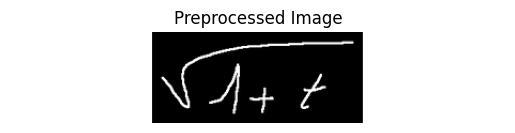

In [65]:
idx = random.randint(0, len(train_dataset) - 1)
img_tensor, label_tensor = train_dataset[idx]

print(f"Figure shape: {img_tensor.shape}")  # 应为 (3, 85, 464)
print(f"Label shape: {label_tensor.shape}")  # 应为 (max_seq_length,)

plt.imshow(img_tensor.permute(1, 2, 0).numpy(), cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()


In [66]:
import random

# 随机挑选 5 个样本索引
sample_indices = random.sample(range(len(train_dataset)), 5)

for i, idx in enumerate(sample_indices, 1):
    img_tensor, label_tensor = train_dataset[idx]
    
    # 解码标签序列
    tokens = [idx2token[idx.item()] for idx in label_tensor 
              if idx.item() not in (token2idx['<pad>'], token2idx['<s>'], token2idx['</s>'])]
    decoded_latex = ' '.join(tokens)

    print(f"\nSample {i}")
    print("Token Length:", len(tokens))
    print("Restore the LaTeX expression:")
    print(decoded_latex)



Sample 1
Token Length: 7
Restore the LaTeX expression:
x ^ { n } = r

Sample 2
Token Length: 16
Restore the LaTeX expression:
n 2 ^ { n - 1 } + 1 - 2 ^ { n }

Sample 3
Token Length: 7
Restore the LaTeX expression:
[ o ^ { q } ]

Sample 4
Token Length: 3
Restore the LaTeX expression:
x + n

Sample 5
Token Length: 24
Restore the LaTeX expression:
\frac   { - b - \sqrt   { b ^ { 2 } - 4 a c } } { 2 a }


In [67]:
# 测试闭环：原始 → 清洗 → 编码 → 解码
sample_idx = random.randint(0, len(latex_codes_raw) - 1)
raw = latex_codes_raw[sample_idx]
cleaned = smart_clean_latex(raw)
encoded = encode_label_mixed(cleaned, token2idx, command_tokens, max_seq_length)

# 去除 padding 特殊 token 后解码
tokens = [idx2token[i] for i in encoded if i not in (token2idx['<pad>'], token2idx['<s>'], token2idx['</s>'])]
decoded = ''.join(tokens)

print("Original Lable:")
print(raw)
print("\nWashed:")
print(cleaned)
print("\nEncoded:")
print(encoded)
print("\nDecoded:")
print(decoded)


Original Lable:
x ( t ) = x ( t - 1 )

Washed:
x(t)=x(t-1)

Encoded:
[  1 107   6 103   7  24 107   6 103  10  14   7   2   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]

Decoded:
x(t)=x(t-1)

In [68]:
batch = next(iter(train_loader))
imgs, labels, lengths = batch

print(f"Batch figure shape: {imgs.shape}")      # (B, 3, 85, 464)
print(f"Batch label shape: {labels.shape}")    # (B, max_seq_length)
print(f"Label Length (first 5): {lengths[:5]}")


Batch figure shape: torch.Size([32, 3, 85, 464])
Batch label shape: torch.Size([32, 224])
Label Length (first 5): [224, 224, 224, 224, 224]
